In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, precision_score
from sklearn.model_selection import train_test_split
from math import sqrt

In [2]:
class LionOptimization:
    def __init__(self, knn, population_size=20, generations=50):
        self.knn = knn
        self.population_size = population_size
        self.generations = generations
        self.best_solution = None
        self.best_score = -np.inf

    def initialize_population(self):
        return np.random.randint(1, 50, size=(self.population_size, 1))

    def fitness(self, solution, X_train, y_train, X_test, y_test):
        k = max(1, int(solution[0]))
        self.knn.n_neighbors = k
        self.knn.fit(X_train, y_train)
        predictions = self.knn.predict(X_test)
        return accuracy_score(y_test, predictions)

    def optimize(self, X_train, y_train, X_test, y_test):
        population = self.initialize_population()
        
        for gen in range(self.generations):
            for i in range(self.population_size):
                score = self.fitness(population[i], X_train, y_train, X_test, y_test)
                if score > self.best_score:
                    self.best_score = score
                    self.best_solution = population[i]
            population = np.clip(population + np.random.randint(-1, 2, size=population.shape), 1, 50)

        return int(self.best_solution[0]), self.best_score

In [3]:
# Load and preprocess the EEG dataset
data = pd.read_csv("Full-EEG.csv")
X = data.drop('Target', axis=1)
y = data['Target']

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Apply Expectation-Maximization
em = EM(n_components=2)
em.fit(X_train)
X_train_em = em.predict_proba(X_train)
X_test_em = em.predict_proba(X_test)

In [6]:
# Initialize KNN and Lion Optimization
knn = KNeighborsClassifier()
lion_opt = LionOptimization(knn)

In [7]:
# Optimize KNN using Lion Optimization
best_k, best_accuracy = lion_opt.optimize(X_train_em, y_train, X_test_em, y_test)

In [8]:
# Final model evaluation with optimized K
knn.n_neighbors = best_k
knn.fit(X_train_em, y_train)
y_pred = knn.predict(X_test_em)

In [9]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
mse = mean_squared_error(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)
fpr = fp / (fp + tn)
error_rate = 1 - accuracy
gmean = sqrt(sensitivity * specificity)

In [10]:
# Print metrics
print(f"Best K: {best_k}")
print(f"Accuracy: {accuracy}")
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"MSE: {mse}")
print(f"G-Mean: {gmean}")
print(f"FPR: {fpr}")
print(f"Error Rate: {error_rate}")
print(f"Precision: {precision}")

Best K: 5
Accuracy: 0.8636363636363636
Sensitivity (Recall): 0.9166666666666666
Specificity: 0.8170731707317073
MSE: 0.13636363636363635
G-Mean: 0.8654384668117071
FPR: 0.18292682926829268
Error Rate: 0.13636363636363635
Precision: 0.8148148148148148


In [15]:
# Dictionary of metrics
metrics = {
    "Best K": [best_k],
    "Accuracy": [accuracy],
    "Sensitivity": [sensitivity],
    "Specificity": [specificity],
    "MSE": [mse],
    "G-Mean": [gmean],
    "FPR": [fpr],
    "Error Rate": [error_rate],
    "Precision": [precision]
}

# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame(metrics)

# Save metrics to a CSV file
metrics_df.to_csv("model_evaluation_metrics.csv", index=False)

print("Metrics saved to model_metrics.csv")


Metrics saved to model_metrics.csv


Text(0.5, 1.0, 'Confusion Matrix')

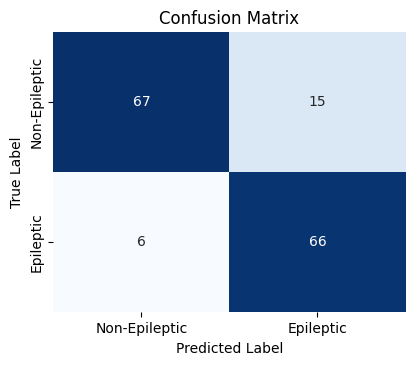

In [11]:
# Visualization
plt.figure(figsize=(10, 8))

# Confusion Matrix Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Non-Epileptic", "Epileptic"], 
            yticklabels=["Non-Epileptic", "Epileptic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

Text(0.5, 1.0, 'Accuracy over Generations (LOA)')

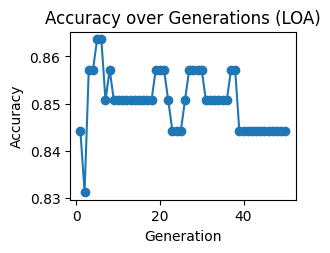

In [12]:
# Accuracy over Generations
plt.subplot(2, 2, 2)
generations = range(1, lion_opt.generations + 1)
accuracies = [lion_opt.fitness([k], X_train_em, y_train, X_test_em, y_test) for k in generations]
plt.plot(generations, accuracies, marker='o')
plt.xlabel("Generation")
plt.ylabel("Accuracy")
plt.title("Accuracy over Generations (LOA)")

/tmp/ipykernel_17965/199892781.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Sensitivity", "Specificity"], y=[sensitivity, specificity], palette="viridis")


Text(0.5, 1.0, 'Sensitivity and Specificity')

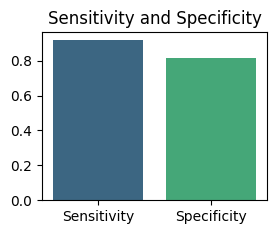

In [13]:
# Sensitivity and Specificity
plt.subplot(2, 2, 3)
sns.barplot(x=["Sensitivity", "Specificity"], y=[sensitivity, specificity], palette="viridis")
plt.title("Sensitivity and Specificity")

/tmp/ipykernel_17965/1937591966.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Error Rate", "FPR"], y=[error_rate, fpr], palette="coolwarm")


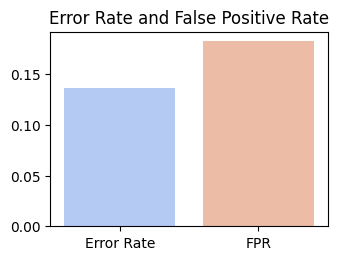

In [14]:
# Error Rate vs. FPR
plt.subplot(2, 2, 4)
sns.barplot(x=["Error Rate", "FPR"], y=[error_rate, fpr], palette="coolwarm")
plt.title("Error Rate and False Positive Rate")

plt.tight_layout()
plt.show()